In [1]:
# Standard library imports
import sys
import warnings


# Third-party library imports
import pandas as pd
import scipy.stats as stats
import xgboost as xg
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Adding 'src' folder path to import path
sys.path.append('../src')

# Local application imports (custom modules)
from classes import Auxiliaries, Modelling, Plot

In [2]:
# Create objects for data visualization and modeling
plotter = Plot(figsize=(10, 6), palette='viridis')
modelling = Modelling()
aux = Auxiliaries(plotter)

# Ignore warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# read the csv file
data = pd.read_csv("../data/teste_indicium_precificacao.csv")

In [4]:
# convert 'ultima_review' in data format
data['ultima_review'] = pd.to_datetime(data['ultima_review'])

# Análise Explorátoria dos Dados

##  Análise por Bairro - ```bairro_group```

A seguir, analisamos a variável `bairro_group`, que indica o bairro onde cada anúncio está localizado.       

Observamos que a maioria dos anúncios estão concentrados em **Manhattan** e no **Brooklyn**, que juntos representam mais de 80% do total. **Manhattan** se destaca como o bairro com a maior quantidade de anúncios, correspondendo a 44,3% do total, seguido pelo Brooklyn, que representa pouco mais de 40%.    

Os demais bairros — **Queens**, **Bronx** e **Staten Island** — possuem uma participação menor no número de anúncios. Queens e Bronx representam cada um menos de 12%, enquanto **Staten Island** apresenta a menor proporção, com apenas 0,8% dos anúncios.

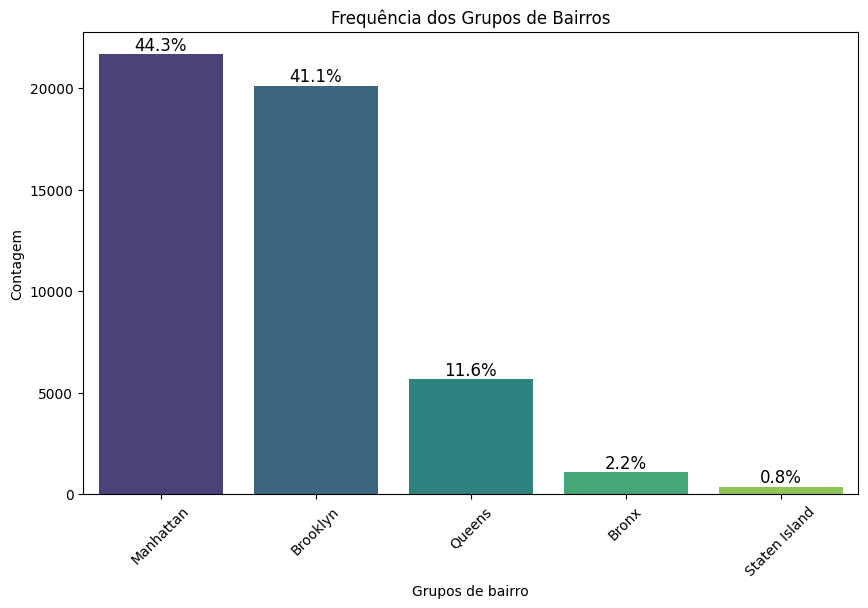

In [5]:
# bairro group count
bairro_group_count = data['bairro_group'].value_counts().reset_index()
bairro_group_count.columns = ['bairro_group', 'count']

# Using Plot class to plot bar graph
plotter.barplot(data=bairro_group_count, x_col='bairro_group', y_col='count', 
             title='Frequência dos Grupos de Bairros', xlabel='Grupos de bairro', ylabel='Contagem',
             rotation=45,show_percentage=True)  


A seguir, analisamos também o preço médio dos grupos de bairros. Observamos que os dois bairros com maior número de anúncios, **Manhattan** e **Brooklyn**, também apresentam os preços médios mais elevados. Manhattan possui o maior valor, com uma média de 197 dólares por noite, enquanto o **Brooklyn** apresenta um preço médio de 124 dólares.    

Nos bairros com menor quantidade de anúncios, a relação entre participação e preço médio se altera. Apesar de **Staten Island**representar apenas 0,8% dos anúncios, seu preço médio é de 115 dólares, superior ao de Queens e Bronx. Além disso, o valor médio de **Staten Island** se aproxima do preço médio do **Brooklyn**, destacando-se entre os bairros com menor número de anúncios.

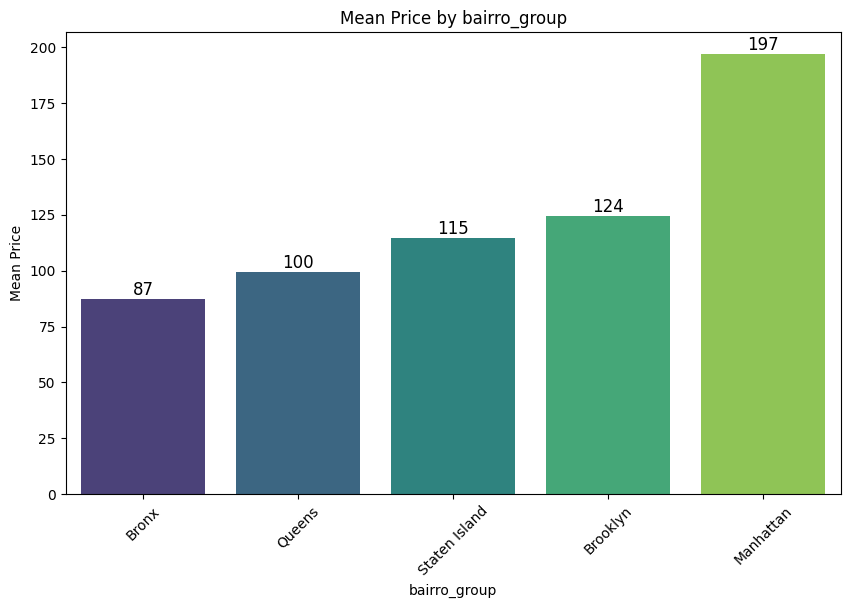

In [6]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby('bairro_group')['price'].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(data=mean_price_by_room_type_df, x_col='bairro_group', y_col='price', 
             title='Mean Price by bairro_group', xlabel='bairro_group', ylabel='Mean Price',
             rotation=45,show_percentage=False)

Na análise a seguir, observamos um comportamento interessante: os dois bairros com maior número de anúncios apresentam os menores números médios de avaliações. **Manhattan** possui, em média, 21 avaliações por anúncio, enquanto **Brooklyn** tem 24.    

Por outro lado, os bairros com menor quantidade de anúncios se destacam por terem um maior número médio de avaliações. **Staten Island** apresenta a maior média, com 31 avaliações por anúncio, seguido por **Queens**, com 28, e **Bronx**, com 26. Esse resultado contrasta com as análises anteriores, indicando que, embora **Manhattan** e **Brooklyn** concentrem a maior parte dos anúncios e tenham os preços mais elevados, os bairros com menos anúncios parecem ter uma maior interação dos hóspedes, refletida no maior número de avaliações.

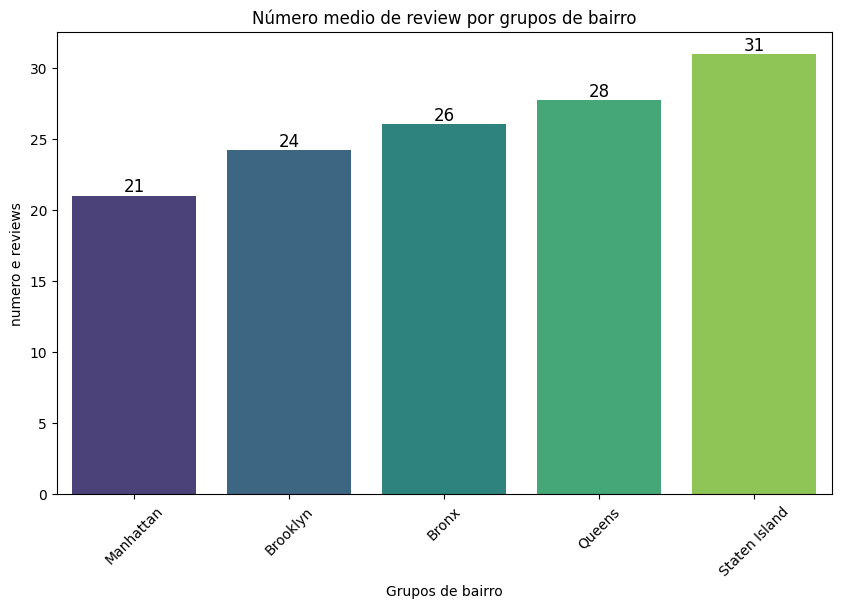

In [7]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby('bairro_group')['numero_de_reviews'].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(data=mean_price_by_room_type_df, x_col='bairro_group', y_col='numero_de_reviews', 
             title='Número medio de review por grupos de bairro', xlabel='Grupos de bairro', ylabel='numero e reviews',
             rotation=45,show_percentage=False)


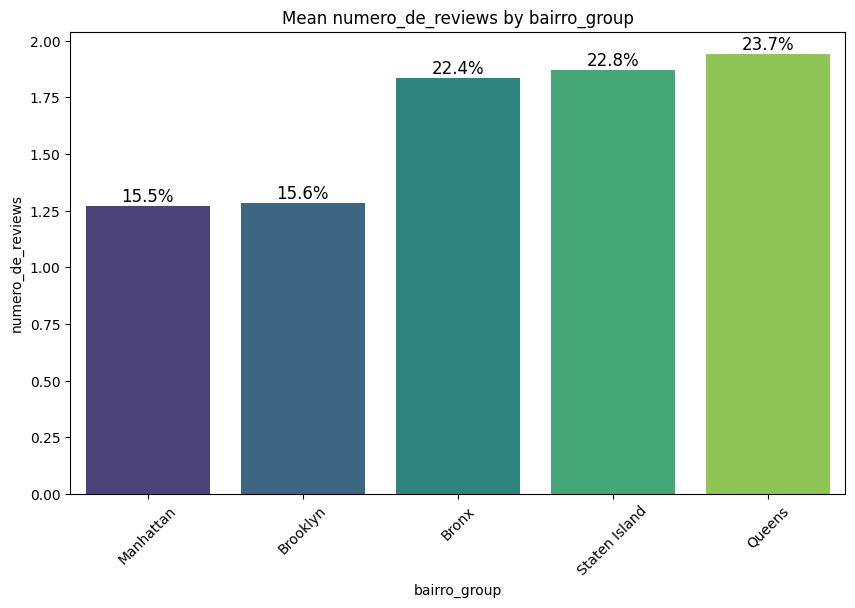

In [8]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby('bairro_group')['reviews_por_mes'].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(data=mean_price_by_room_type_df, x_col='bairro_group', y_col='reviews_por_mes', 
             title='Mean numero_de_reviews by bairro_group', xlabel='bairro_group', ylabel='numero_de_reviews',
             rotation=45)


## Análise por nome e textos - ```nome```

Abaixo, apresentamos a análise dos nomes mais comuns na variável `nome`, que representa o título do anúncio.  

Essas palavras são utilizadas para atrair clientes e fornecer uma breve descrição do espaço. Entre as mais frequentes, destacam-se:  

- **heart** – coração  
- **private** – privado  
- **room** – quarto  
- **apartment** – apartamento  
- **cozy** – aconchegante  
- **home** – lar/casa  
- **spacious** – espaçoso  

Essas palavras enfatizam o conforto e as características do local, ajudando a tornar os anúncios mais atrativos para os possíveis hóspedes.

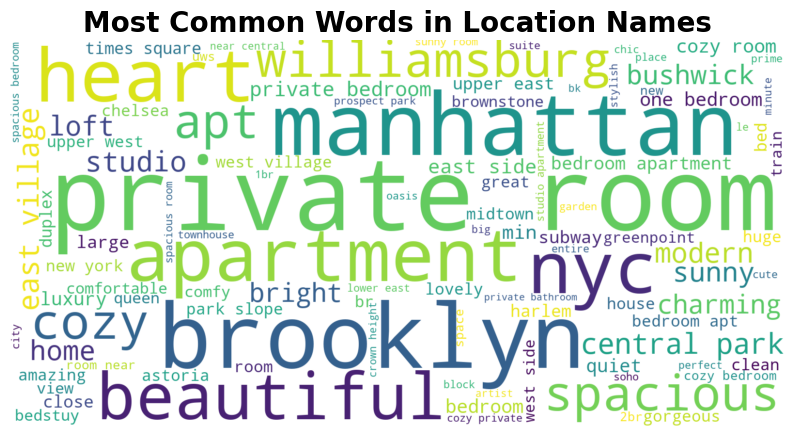

In [9]:
# Generate a word cloud for the 'nome' column in the 'data' DataFrame
df_commom_words = plotter.plot_wordcloud(data, text_column='nome', title="Palavras mais comuns nos nomes do anuncio")


## Análise por gênero - ```host_name```

Para a análise a seguir, realizamos um pré-processamento nos dados e criamos uma nova coluna a partir da variável `host_name`, que contém o nome do anfitrião do anúncio. O objetivo foi identificar o gênero do anunciante, permitindo avaliar possíveis diferenças nos preços ou no número de anúncios com base nesse critério.  

Os resultados mostram que a categoria mais comum é "Andy" ou andróginos – nomes que não conseguimos classificar com precisão –, representando 26% do total. Além disso, alguns nomes não puderam ser rotulados como masculinos ou femininos, sendo categorizados como "Desconhecido".  

No geral, observamos que há mais anfitriões do gênero masculino do que feminino, com os homens representando 24,8% dos anúncios, enquanto as mulheres correspondem a 21,2%.

['female' 'unknown' 'male' 'andy']


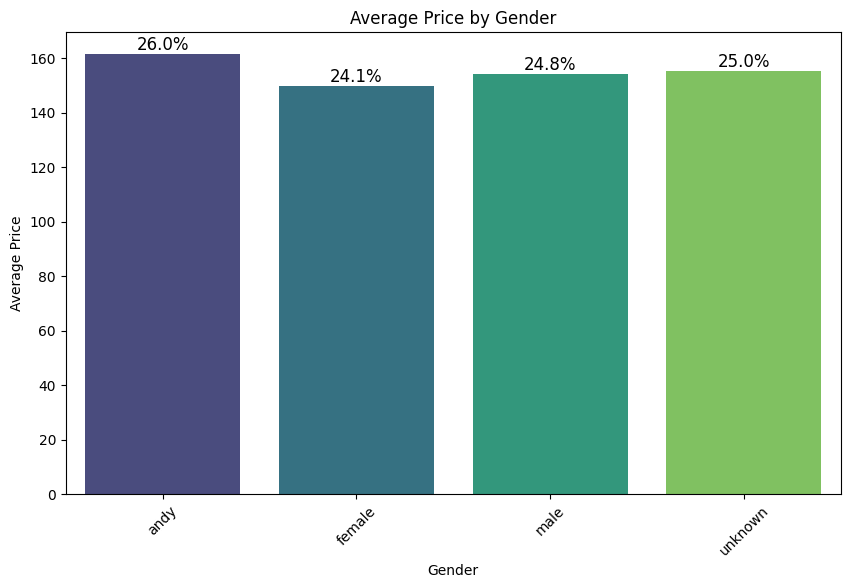

In [10]:
# Aplicate predict_gender in col 'host_name'
data['gender'] = data['host_name'].apply(lambda name: aux.predict_gender(name))

# Replace specific gender values for consistency
data['gender'] = data['gender'].replace({'mostly_female': 'female', 'mostly_male': 'male'})

# Check the unique values in the 'gender' column
print(data['gender'].unique())

# Group by 'gender' and calculate the mean price
gender_price_mean = data.groupby('gender')['price'].mean().reset_index()

# Use the Plot class to generate a bar chart
plotter.barplot(data=gender_price_mean, x_col='gender', y_col='price',
                title='Average Price by Gender', xlabel='Gender', ylabel='Average Price',
                rotation=45)


## Análise de Preços - ```price```

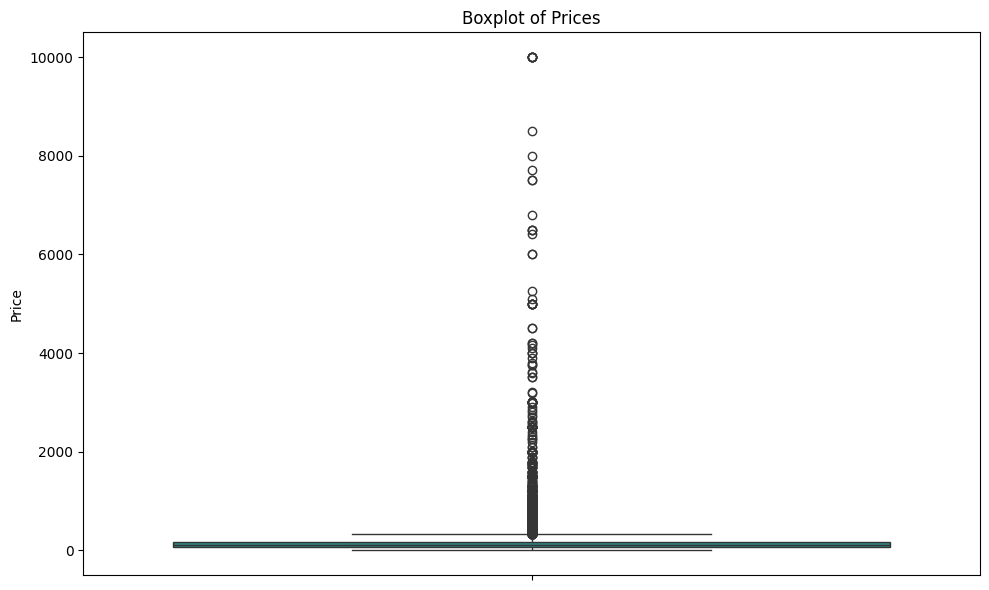

In [11]:
# Plot the boxplot for 'price' (without x_col)
plotter.boxplot(data=data, x_col= None,y_col='price', title='Boxplot of Prices', ylabel='Price')

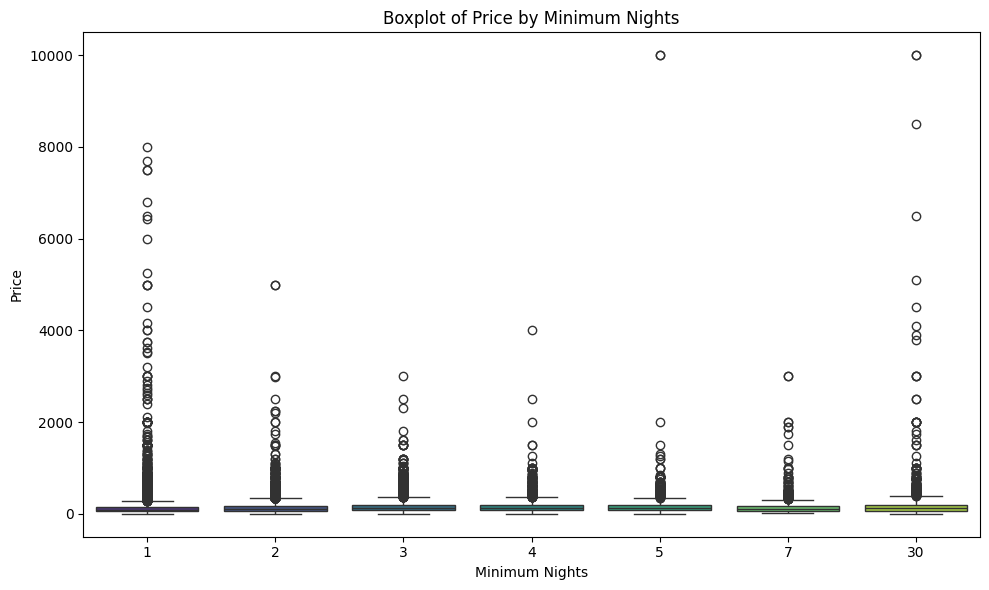

Mean prices by Minimum Nights:
minimo_noites
1     142.02
2     146.27
3     160.25
4     161.19
5     157.31
7     141.19
30    182.56
Name: price, dtype: float64


In [12]:
# Define the most common values of 'minimo_noites'
common_nights = [1, 2, 3, 30, 4, 5, 7]

# Filter the dataset to include only these values
filtered_data = data[data['minimo_noites'].isin(common_nights)]

# Create the boxplot for 'minimo_noites' using the Plot class
plotter.boxplot(data=filtered_data, x_col='minimo_noites', y_col='price',
                title='Boxplot of Price by Minimum Nights', xlabel='Minimum Nights', ylabel='Price')

# Calculate and print the mean prices by 'minimo_noites'
mean_prices = filtered_data.groupby('minimo_noites')['price'].mean()
print("Mean prices by Minimum Nights:")
print(mean_prices.round(2))


In [13]:
data['days_since_last_review'] = (pd.Timestamp.today() - data['ultima_review']).dt.days



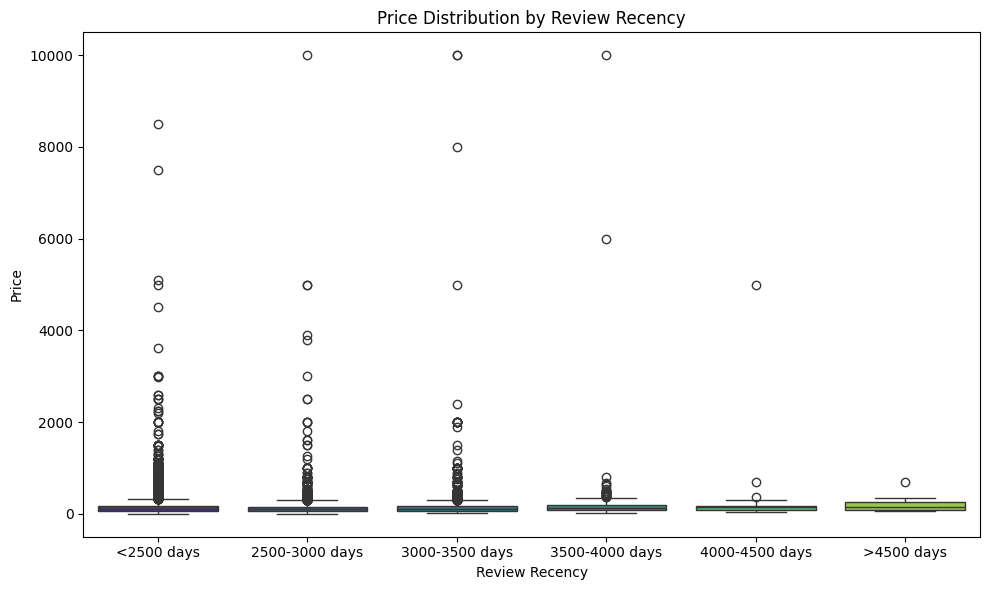

In [14]:
data['days_since_last_review'] = (pd.Timestamp.today() - data['ultima_review']).dt.days


# Ensure there are no NaN values in 'days_since_last_review'
data = data.dropna(subset=['days_since_last_review'])

# Define the bins with a lower bound (0)
data['review_recency_category'] = pd.cut(
    data['days_since_last_review'], 
    bins=[0, 2500, 3000, 3500, 4000, 4500, data['days_since_last_review'].max()], 
    labels=['<2500 days', '2500-3000 days', '3000-3500 days', '3500-4000 days', '4000-4500 days', '>4500 days']
)

# Drop NaN values again in case some remain
data = data.dropna(subset=['review_recency_category', 'price'])


plotter.boxplot(data=data, x_col='review_recency_category', y_col='price',
                title='Price Distribution by Review Recency', xlabel='Review Recency', ylabel='Price')



A p-value de 5.900678200832663e-07 é extremamente baixa (muito menor que 0.05). Isso significa que:

Rejeitamos a hipótese nula: A hipótese nula, nesse caso, era que todas as categorias de "review_recency_category" têm médias de preço iguais.
Diferenças significativas: Há evidências estatísticas fortes de que, pelo menos, uma das categorias tem uma média de preço diferente das outras.
Influência da recência: Isso sugere que a data da última avaliação (ou a recência) tem um efeito significativo sobre o preço, ou seja, os preços variam de forma estatisticamente significativa entre os diferentes grupos de recência das avaliações.
Em resumo, com esse p-value, você pode concluir que a variável "days_since_last_review" (transformada em categorias) influencia o preço de maneira significativa.

In [15]:
anova_result = stats.f_oneway(
    *[group['price'].dropna() for _, group in data.groupby('review_recency_category')]
)
print("Se o valor p < 0,05, então a última data de revisão afeta significativamente o preço.")
print("Se o valor p > 0,05, não há evidências fortes de que a atualidade da revisão impacta o preço.")
print(f"ANOVA p-value: {anova_result.pvalue}")

Se o valor p < 0,05, então a última data de revisão afeta significativamente o preço.
Se o valor p > 0,05, não há evidências fortes de que a atualidade da revisão impacta o preço.
ANOVA p-value: 4.806640771930744e-07


# questions 

## A

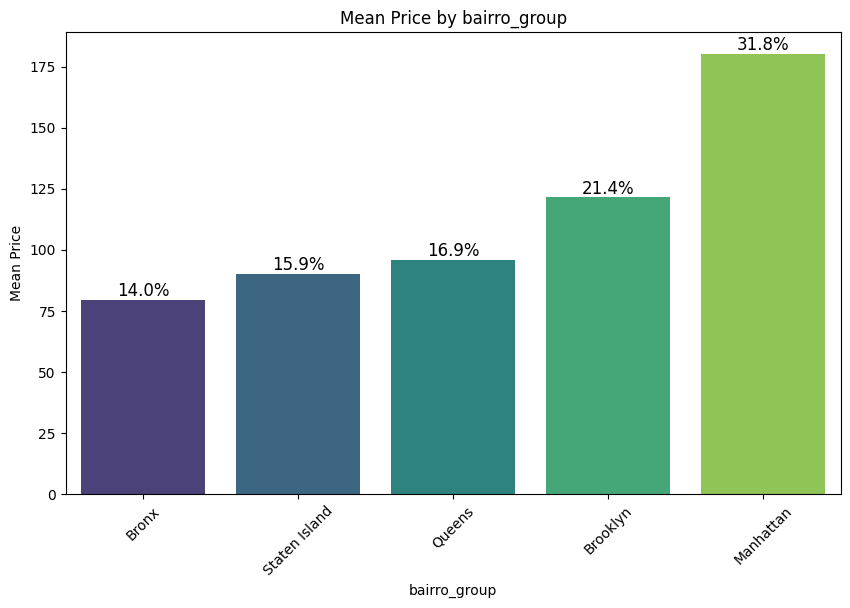

In [16]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby('bairro_group')['price'].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(data=mean_price_by_room_type_df, x_col='bairro_group', y_col='price', 
             title='Mean Price by bairro_group', xlabel='bairro_group', ylabel='Mean Price',
             rotation=45)

## B

### b.1

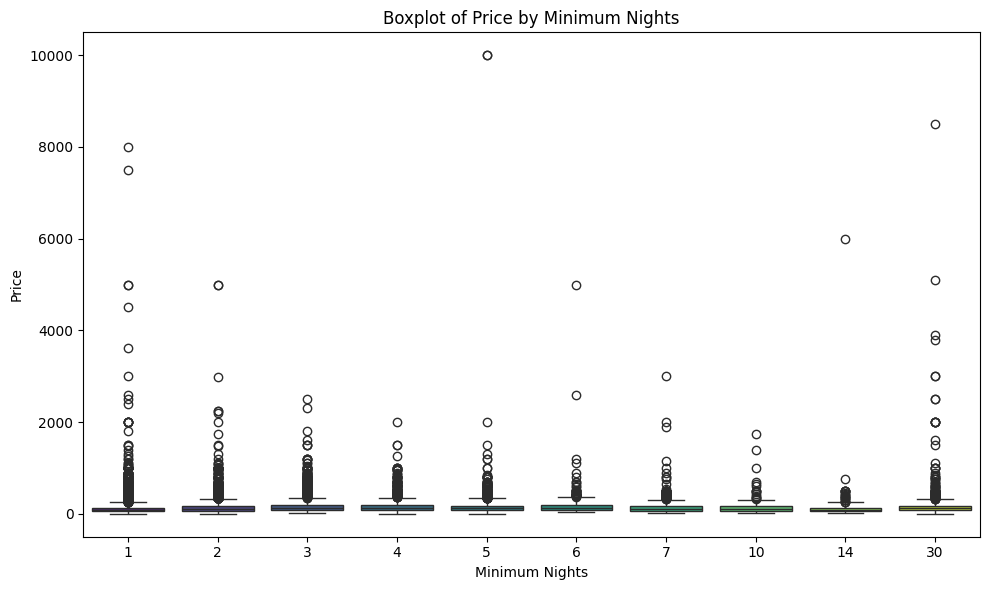

Mean prices by Minimum Nights:
minimo_noites
1     122.64
2     141.69
3     155.55
4     156.83
5     157.05
6     166.77
7     132.95
10    137.97
14    126.88
30    159.46
Name: price, dtype: float64


In [17]:
# Define the most common values of 'minimo_noites'
common_nights = data['minimo_noites'].value_counts().head(10).index

# Filter the dataset to include only these values
filtered_data = data[data['minimo_noites'].isin(common_nights)]

# Create the boxplot for 'minimo_noites' using the Plot class
plotter.boxplot(data=filtered_data, x_col='minimo_noites', y_col='price',
                title='Boxplot of Price by Minimum Nights', xlabel='Minimum Nights', ylabel='Price')

# Calculate and print the mean prices by 'minimo_noites'
mean_prices = filtered_data.groupby('minimo_noites')['price'].mean()
print("Mean prices by Minimum Nights:")
print(mean_prices.round(2))



In [18]:
# Remove any rows with missing values in 'disponibilidade_365' or 'price'
clean_data = data.dropna(subset=['minimo_noites', 'price'])

# Perform ANOVA (Analysis of Variance)
anova_result = stats.f_oneway(*(clean_data[clean_data['minimo_noites'] == value]['price'] 
                               for value in clean_data['minimo_noites'].unique()))

# Print the results
print("ANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic:.2f}")
print(f"P-value: {anova_result.pvalue:.4f}")

# Interpretation of the results
if anova_result.pvalue < 0.05:
    print("There is a significant relationship between 'minimo_noites' and 'price'.")
else:
    print("There is no significant relationship between 'minimo_noites' and 'price'.")

ANOVA Test Results:
F-statistic: 37.85
P-value: 0.0000
There is a significant relationship between 'minimo_noites' and 'price'.


### b.2

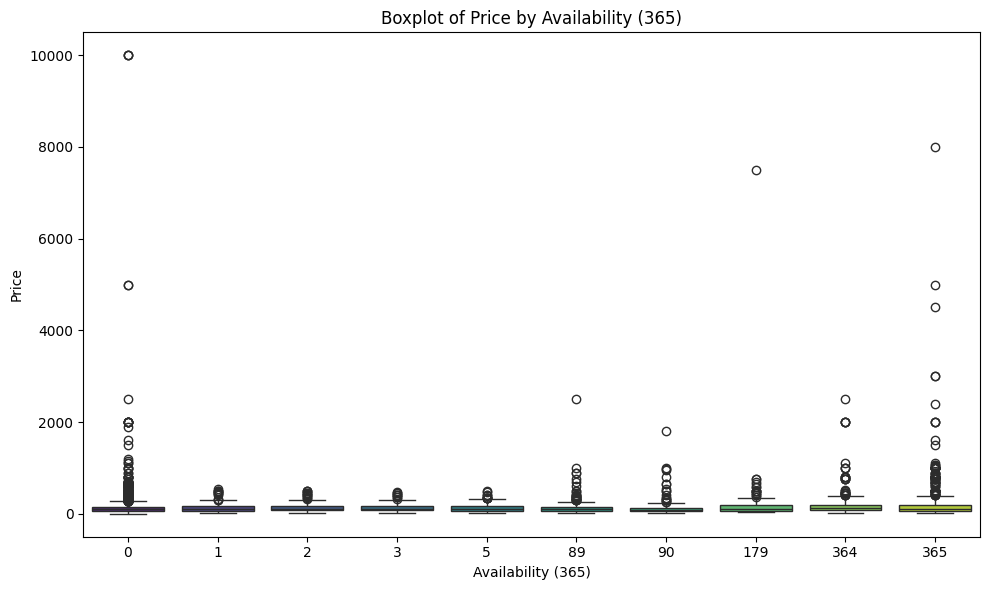

Mean prices by Availability (365):
disponibilidade_365
0      126.72
1      126.85
2      136.12
3      133.15
5      132.08
89     146.32
90     135.42
179    183.57
364    205.46
365    214.05
Name: price, dtype: float64


In [19]:
# Define the most common values of 'disponibilidade_365'
common_availability = data['disponibilidade_365'].value_counts().head(10).index

# Filter the dataset to include only these values
filtered_data_availability = data[data['disponibilidade_365'].isin(common_availability)]

# Create the boxplot for 'disponibilidade_365' using the Plot class
plotter.boxplot(data=filtered_data_availability, x_col='disponibilidade_365', y_col='price',
                title='Boxplot of Price by Availability (365)', xlabel='Availability (365)', ylabel='Price')

# Calculate and print the mean prices by 'disponibilidade_365'
mean_prices_availability = filtered_data_availability.groupby('disponibilidade_365')['price'].mean()
print("Mean prices by Availability (365):")
print(mean_prices_availability.round(2))

In [20]:
# Remove any rows with missing values in 'disponibilidade_365' or 'price'
clean_data = data.dropna(subset=['disponibilidade_365', 'price'])

# Perform ANOVA (Analysis of Variance)
anova_result = stats.f_oneway(*(clean_data[clean_data['disponibilidade_365'] == value]['price'] 
                               for value in clean_data['disponibilidade_365'].unique()))

# Print the results
print("ANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic:.2f}")
print(f"P-value: {anova_result.pvalue:.4f}")

# Interpretation of the results
if anova_result.pvalue < 0.05:
    print("There is a significant relationship between 'disponibilidade_365' and 'price'.")
else:
    print("There is no significant relationship between 'disponibilidade_365' and 'price'.")


ANOVA Test Results:
F-statistic: 1.75
P-value: 0.0000
There is a significant relationship between 'disponibilidade_365' and 'price'.


### 2.c

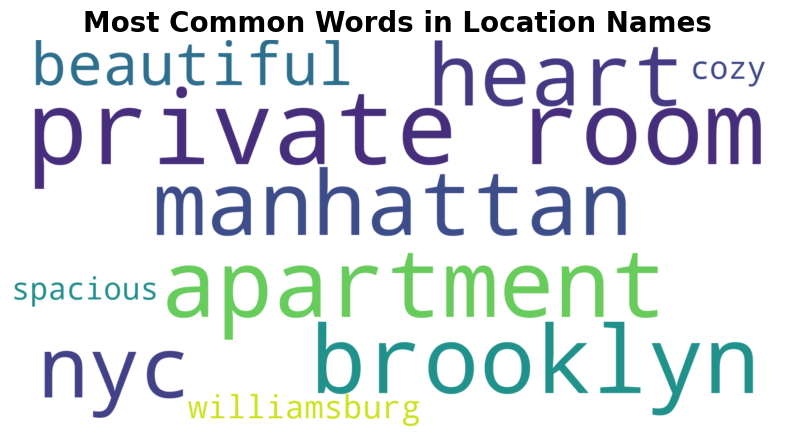

In [21]:
# Generate a word cloud for the 'nome' column in the 'data' DataFrame
df_words = plotter.plot_wordcloud(data, text_column='nome', max_words=10,title="Most Common Words in Location Names")


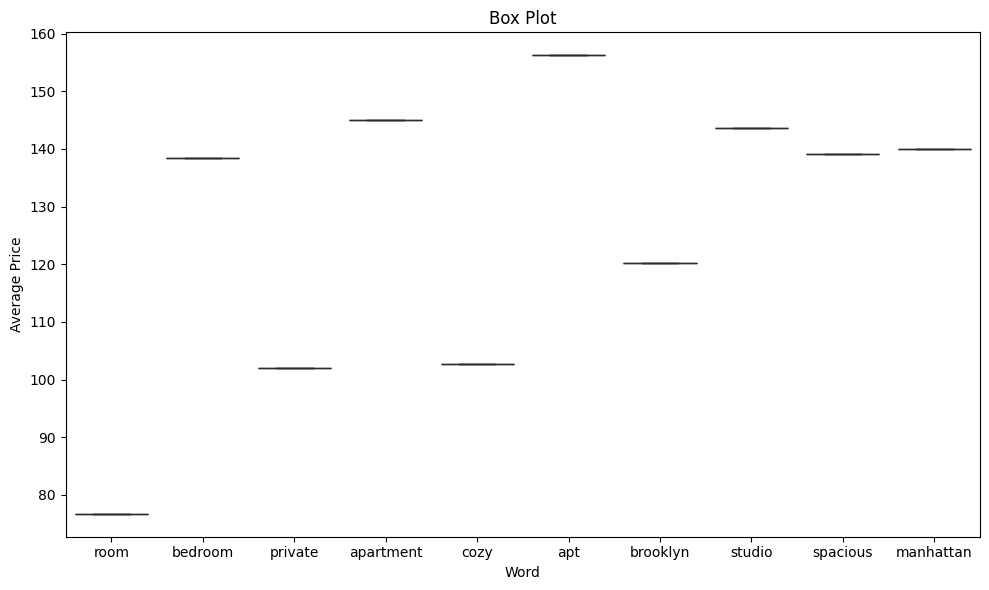

In [22]:
# plot price distribuitions form common word
df_price_distribution = aux.plot_price_distribution(data, 'nome', 'price', df_words)

# Modelling

In [23]:
data_modelling = data.copy()

# Define the collumns
categorical_features = [
    "bairro_group", "bairro", "room_type", "gender"
    ]
numerical_features = [
    "minimo_noites", "numero_de_reviews", "reviews_por_mes",
    "calculado_host_listings_count", "disponibilidade_365", "days_since_last_review"
]

# Remove rows with NaN values
data_modelling = data_modelling.dropna() 

# Transformer for categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Transformer for numeric variables (no transformation applied)
numerical_transformer = "passthrough"

# Applying transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),  # Passing numerical features as they are
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])



In [24]:
# separate columns features and target
y = data_modelling["price"]
X = data_modelling.drop(columns=["price"])

# Divisão em treino (70%) e temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Divisão do temporário em validação (20%) e teste (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Aplicando as transformações do pipeline
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)


# Regressão Linear

Os resultados da regressão linear mostram um desempenho relativamente baixo do modelo na predição dos dados. Primeiramente, a escolha do hiperparâmetro fit_intercept=False indica que o modelo foi treinado sem um termo de interceptação, assumindo que os dados já estavam centralizados ou que a relação entre as variáveis explicativas e a variável-alvo não requer um deslocamento adicional.

O coeficiente de determinação 𝑅², que mede a proporção da variância explicada pelo modelo, é de 0,2288 para o conjunto de validação. Esse valor sugere que apenas cerca de 22,88% da variação da variável dependente é explicada pelo modelo, indicando um ajuste fraco.

Nas métricas de erro, o Erro Médio Absoluto (MAE) foi 59,63, o que indica o erro médio em unidades da variável predita. Esse valor sugere que, em média, as previsões do modelo se desviam cerca de 59,63 unidades dos valores reais.

O Theil’s U foi 0,4439, o que indica que o modelo possui um erro considerável em relação a uma previsão ingênua (como uma previsão baseada na média passada). Em geral, valores de Theil próximos de 0 indicam boas previsões, enquanto valores acima de 1 sugerem um modelo pouco útil. O valor obtido (próximo de 0,44) indica que o modelo tem um desempenho melhor do que uma previsão ingênua, mas ainda apresenta limitações.

No geral, os resultados sugerem que a regressão linear não capturou adequadamente a relação entre as variáveis do conjunto de dados.

In [25]:
# Define the model and parameter grid
model_lr = LinearRegression()


param_grids_lr = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
}

# Configure GridSearchCV (without automatic refitting)
grid_search_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grids_lr['Linear Regression'],
    scoring='r2',
    cv=5,  
    n_jobs=-1,
    refit=True  
)


best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_lr,
    grid_search=grid_search_lr,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)

------------------------------Melhores Hyperparametros------------------------------
fit_intercept: True
--------------------------------------------------------------------------------
------------------------------R2 Metrics for the Model------------------------------
R² for the validation set: 0.23

------------------------------Métricas de erro para os modelos------------------------------
              model        MAE        R2     theil
0  LinearRegression  59.498186  0.106877  0.443914


In [ ]:
# Define the model
model_xg = xg.XGBRegressor()


# Define the hyperparameter grid for tuning
param_grids_xg = {
    'XGBoost': {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [40, 50],
        'max_depth': [15, 25],
        'min_child_weight': [1, 10],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0.1, 0.5],
        'reg_alpha': [1e-5, 0.1],
        'reg_lambda': [1e-5, 0.1]
    }
}

# Configure GridSearchCV for hyperparameter tuning
grid_search_xg = GridSearchCV(
    estimator=xg.XGBRegressor(), 
    param_grid=param_grids_xg['XGBoost'],
    scoring="r2",
    cv=5,
    n_jobs=-1, 
    refit=True
)

best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_xg,
    grid_search=grid_search_xg,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)


In [ ]:
# Define the model
model_rf = RandomForestRegressor()


# Define the hyperparameter grid for tuning
param_grids_rf = {
    'Random Forest': {
        'n_estimators': [40, 50],
        'max_depth': [None, 30, 40],
        'min_samples_split': [2, 8],
        'min_samples_leaf': [1, 9],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
}

# Configure GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(), 
    param_grid=param_grids_rf['Random Forest'], 
    scoring='r2',
    cv=5,
    n_jobs=-1
)

best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_rf,
    grid_search=grid_search_rf,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)


: 